In [1]:
import sparg
import msprime, pyslim, tskit
import numpy as np
import os
import matplotlib.pyplot as plt

# Estimating dispersal

## A simple check

We first generate a tree sequence with a single tree and ```n``` samples using ```msprime```

In [2]:
n = 100
Ne = 5000
ts = msprime.simulate(sample_size=n, Ne=Ne, random_seed=1)
ts

Now let's use ```sparg``` to process this tree, getting the shared times between each sample lineage

In [3]:
which_trees = [0]
trees = sparg.trees.get_dendropy_trees(treefile=ts, which_trees=which_trees, from_ts=True) #first we convert to dendropy (this will likely change in future releases, it would be nice to just stick with tskit)
shared_times, samples = sparg.trees.process(trees, important=False) #then we use sparg to process the trees, calculating the shared times and the positions of each sample node

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Now, to do a simple check, we'll position the samples as if they were located based on Brownian motion down the first tree with variance ```sigma**2``` in x and y and no covariance

In [4]:
sigma = 0.5 #dispersal rate (SD in both dimensions)
np.random.seed(1)
xs, ys = np.random.multivariate_normal(mean = np.zeros(n), cov = sigma**2 * shared_times[0][0][0], size = 2) #simulate the sample locations
ix = [np.where(np.array(samples[0][0][0]) == i)[0][0] for i in range(n)] #clunky way to get order of samples
locations = np.array([[xs[i], ys[i]] for i in ix])

And then we can use ```sparg``` to estimate dispersal at this tree

In [5]:
x0 = [0.5, 0.5, 0] #initial guess for parameters (sd in x, sd in y, correlation bw x and y)
bnds = ((1e-6,None), (1e-6,None), (-0.99,0.99)) # bounds on the parameters (eg to keep the sd's positive)

mle = sparg.dispersal.estimate(locations=locations, shared_times=shared_times, samples=samples, important=False, x0=x0, bnds=bnds)

searching for maximum likelihood parameters...
the max is  [0.44555878 0.47425229 0.09902776]
finding the max took 0.26665592193603516 seconds


Good, the SD in x and y (the first two numbers, respectively) are both close to sigma and the correlation (the final number) is close to 0.

In this case we can actually just calculate the mle analytically, as a check that the numerical optimizer is working

In [6]:
Sigma = sparg.dispersal.mle(locations=locations[samples[0][0][0]], shared_time=shared_times[0][0][0]) #here we use the first subtree of the first sample at the first locus
Sigma[0,0]**0.5, Sigma[1,1]**0.5, Sigma[0,1] / (Sigma[0,0]**0.5 * Sigma[1,1]**0.5) #convert from covariance matrix to SDs and correlation

(0.44555814366259705, 0.4742503231544016, 0.0990334160857666)

## Maximum composite likelihood dispersal

Now let's run an actual spatial simulation, in SLiM (www.messerlab.org/slim), and see if we can estimate the dispersal rate using many trees.

First make a function to create and run a SLiM script

In [7]:
def run_simulation(L, RBP, LAMBDA, K, W, SIGMA_int, SIGMA_disp, MAXT, fname, SLiM):
    
    script='''

    //adapted from https://pyslim.readthedocs.io/en/latest/vignette_space.html

    initialize() {

        //setSeed(1); // set seed for repeatability
        initializeSLiMModelType("nonWF"); // non Wright Fisher
        initializeSLiMOptions(dimensionality="xy"); // two spatial dimensions
        initializeTreeSeq(retainCoalescentOnly=F); // record the true tree sequence (and keep unary nodes too, for locating ancestors, later)

        defineConstant("L", %d); // length of chromosome
        defineConstant("RBP", %.8f); // per base pair recombination rate
        defineConstant("LAMBDA", %f); // mean offspring per parent when no competition
        defineConstant("K", %f);      // carrying capacity per unit area
        defineConstant("W", %f);      // width and height of the area
        defineConstant("SIGMA_int", %f);  // sd of interaction (competition and mating)
        defineConstant("SIGMA_disp", %f); // sd of dispersal (both dimensions) kernels
        defineConstant("filename", "%s"); // where to save output

        initializeMutationRate(0.0); // no mutations (add these with msprime)
        initializeMutationType("m1", 0.5, "f", 0.0); // irrelevant mutation type
        initializeGenomicElementType("g1", m1, 1.0); // irrelevant genome type
        initializeGenomicElement(g1, 0, L-1); // length of chromosome
        initializeRecombinationRate(RBP); // recombination rate per base

        // spatial interaction for local competition and mate choice
        initializeInteractionType("i1", "xy", reciprocal=T, maxDistance = 3*SIGMA_int); // define interaction type i1, in two spatial dimensions, where individual A has the same effect on B that B does on A (this speeds up computation), and only individuals within distance 3*SIGMA interact (again to speed things up)  
        i1.setInteractionFunction("n", 1.0/(2*PI*SIGMA_int^2), SIGMA_int); // convert distance to interaction strength using a Gaussian (n for normal), with maximum value 1/(2*pi*sigma**2) and standard deviation sigma (ie, this is truly and normal PDF with mean 0 and variance sigma**2)
    }

    reproduction() {
        neighbor_density = i1.totalOfNeighborStrengths(individual); // sum of interaction strengths
        num_offspring = rpois(1, LAMBDA / (1 + neighbor_density / K)); // poisson number of offspring with mean LAMBDA/(1+n_d/K), ie Beverton-Holt density dependence
        mate = i1.drawByStrength(individual, 1);  // single mate for all offspring (ie monogamy), with mate chosen randomly based on interaction strength
        if (size(mate) > 0) { // if there is a mate (possible none within interacting distance, in which case there are no offspring produced)
            for (k in seqLen(num_offspring)) {
                offspring = p1.addCrossed(individual, mate); //make offspring by sexual reproduction
                pos = individual.spatialPosition + rnorm(2, 0, SIGMA_disp); // set position of offspring as random normal in both directions
                offspring.setSpatialPosition(p1.pointReflected(pos)); // put offspring in its place
            }
        }
    }

    1 early() {
        sim.addSubpop("p1", asInteger(round(K * W * W))); //set population size at carrying capacity
        p1.setSpatialBounds(c(0.0, 0.0, W, W)); //set spatial plane
        p1.individuals.setSpatialPosition(p1.pointUniform(asInteger(round(K*W*W)))); // start with uniform distribution across range
    }

    early() { // survival probabilities
        p1.fitnessScaling = 1;
        inds = sim.subpopulations.individuals;
        inds[inds.age > 0].fitnessScaling = 0.0; // remove adults (ie enforce discrete generations)

        sim.treeSeqRememberIndividuals(p1.individuals, permanent=F); // retain individuals remaining in the tree sequence (for locating ancestors, later)
        
    }

    late() {
        i1.evaluate(); //calculate interactions
    }

    %d late () {
        sim.treeSeqOutput(filename); //output treesequence
        catn("Done.");
        sim.simulationFinished();
    }
    
    ''' %(L, RBP, LAMBDA, K, W, SIGMA_int, SIGMA_disp, fname, MAXT)

    os.system("echo '" + script + "' | " + SLiM) #run this with SLiM from the command line

Choose our parameters

In [2]:
L = 1e8 #number of basepairs
RBP = 5e-9 #per basepair recombination rate
LAMBDA = 2 #offspring per mating without competition
K = 2 #carrying capacity per unit area
W = 50 #width of habitat
SIGMA_int = 0.5 #SD in competition kernel
SIGMA_disp = 0.5 #SD in dispersal kernel
MAXT = 1e4 #number of gens to run it for

datadir = 'data/' #directory where we'll store data files
fname = datadir + 'slim_sim.trees' #filename of full tree sequence
# fname_simple_unary = datadir + 'slim_sim_simple_unary.trees' #filename of simplifed tree sequence with unary nodes
fname_simple = datadir + 'slim_sim_simple.trees' #filename of simplifed tree sequence without unary nodes

SLiM = '$HOME/programs/SLiM_3.6/slim' #where your SLiM executable is

k = 50 #number of individuals to sample
ntrees = 100 #number of trees to process

Because this SLiM simulation takes a while (~ 1 hour, since we're remembering lots of individuals for later), the code below will just load the simplified tree sequence if it exists, and otherwise will create it (you'll need SLiM and some patience)

In [3]:
try:

    # load the simplified tree sequence
    sts = pyslim.load(fname_simple)

except:
    
    try:
        
        # load the full tree sequence
        ts = pyslim.load(fname)
    
    except:
        
        # run the simulation if file doesn't exist (may take ~1 hour as we're keeping track of every individual that ever existed)
        run_simulation(L=L, RBP=RBP, LAMBDA=LAMBDA, K=K, W=W, SIGMA_int=SIGMA_int, SIGMA_disp=SIGMA_disp, MAXT=MAXT, fname=fname, SLiM=SLiM)
        ts = pyslim.load(fname)

    # sample present-day individuals
    inds_alive = ts.individuals_alive_at(0) #individuals alive at sampling time
    inds_alive = [i for i in inds_alive if ts.individual(i).time == 0.0] #just the current gen (their parents are still alive at the time the sim ended)
    np.random.seed(1)
    inds_sampled = np.random.choice(inds_alive, k, replace=False) #select k individuals randomly from current generation

    # get nodes (haploid genomes) of present-day samples
    nodes_sampled = [] #empty vector for nodes
    for ind in inds_sampled: #for each individual
        nodes_sampled.append(ts.individual(ind).nodes[0]) #append first haploid genome
        nodes_sampled.append(ts.individual(ind).nodes[1]) #append second haploid genome

    sts = ts.simplify(nodes_sampled) #dropping the unary nodes to do our inference
    sts.dump(fname_simple)

sts

And then we recapitate the trees so that each has exactly one root, which is what we'll be working with in reality

In [4]:
rsts = sts.recapitate(recombination_rate=RBP, Ne=K*W**2, random_seed=1) #here we choose Ne to be roughly the census size
rsts

Now we subsample ```ntrees``` evenly-spaced trees from the sequence and process them

In [10]:
which_trees = [int(i) for i in np.linspace(0, rsts.num_trees-1, ntrees)] #evenly space these trees along the tree sequence
trees = sparg.trees.get_dendropy_trees(treefile=rsts, which_trees=which_trees, from_ts=True)
shared_times, samples = sparg.trees.process(trees=trees, important=False) #use sparg to process the trees

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

and finally we use ```sparg``` to search for the maximum composite likelihood estimate of the dispersal rate

In [11]:
# first get the locations of the sample nodes
ixs = [rsts.node(i).individual for i in range(2*k)] #individual associated with each sampled node
locations = np.array([rsts.individual(i).location for i in ixs])[:,:2] #location associated with individual of each node

In [152]:
x0 = [SIGMA_disp, SIGMA_disp, 0] #initial guess for parameters (sd in x, sd in y, correlation bw x and y)
bnds = ((1e-6,None), (1e-6,None), (-0.99,0.99)) # bounds on the parameters (eg to keep the sd's positive)

mle = sparg.dispersal.estimate(locations=locations, shared_times=shared_times, samples=samples, important=False, x0=x0, bnds=bnds)

searching for maximum likelihood parameters...
the max is  [ 0.47365796  0.46156066 -0.03706558]
finding the max took 29.270219087600708 seconds


Great, both SDs are close to SIGMA_disp and the correlation is near 0.

### Epochs

One can also estimate dispersal in epochs by providing the split times between them

In [12]:
x0 = [SIGMA_disp, SIGMA_disp, 0, SIGMA_disp, SIGMA_disp, 0] #initial guess for parameters (sd in x, sd in y, correlation bw x and y, for each epoch)
bnds = ((1e-6,None), (1e-6,None), (-0.99,0.99), (1e-6,None), (1e-6,None), (-0.99,0.99)) # bounds on the parameters (eg to keep the sd's positive)

tsplits = [100]

mle_epochs = sparg.dispersal.estimate(locations=locations, shared_times=shared_times, samples=samples, important=False, x0=x0, bnds=bnds, tsplits=tsplits)

searching for maximum likelihood parameters...
the max is  [ 0.39244363  0.31581743  0.09764348  0.53643252  0.56882801 -0.09259949]
finding the max took 89.0264961719513 seconds


The order of parameters is (sd_x, sd_y, rho) for each epoch in chronological order (ie, most distant epoch first, most recent last)

### Time cutoff

It is also possible to chop the trees off (into subtrees) at some time in the past, effectively ignoring more distant times

In [155]:
tCutoff = 1000
shared_times, samples = sparg.trees.process(trees=trees, important=False, tCutoff=tCutoff) #use sparg to process the trees

  0%|          | 0/100 [00:00<?, ?it/s]

In [156]:
x0 = [SIGMA_disp, SIGMA_disp, 0] #initial guess for parameters (sd in x, sd in y, correlation bw x and y)
bnds = ((1e-6,None), (1e-6,None), (-0.99,0.99)) # bounds on the parameters (eg to keep the sd's positive)

mle_cut = sparg.dispersal.estimate(locations=locations, shared_times=shared_times, samples=samples, important=False, x0=x0, bnds=bnds, tCutoff=tCutoff)

searching for maximum likelihood parameters...
the max is  [ 0.50313491  0.49474357 -0.0389421 ]
finding the max took 10.877841711044312 seconds


In a habitat with strong boundaries, we often find we can estimate dispersal more accurately in more recent epochs, or with a time cutoff, as lineages then have less chance of hitting the boundaries and therefore being less spread out then Brownian motion would imply.

## Importance sampling over inferred trees

In practice we will not know the true trees and so will want to infer the trees and then integrate over uncertainty by sampling each tree multiple times. 

We start by inferring a tree sequence from a VCF of the above simulation with Relate (again, this takes a few minutes so the code will just load the inferred tree sequence if it already exists)

In [19]:
filename = 'slim_sim_simple'
fname = datadir + filename
PATH_TO_RELATE = '~/programs/relate_v1.1.4_x86_64_static/' #update this for your machine (download from https://myersgroup.github.io/relate/index.html)
memory = 2 #Gb
U = 5e-9 #per basepair per generation mutation rate
threshold = 0 #what percent of trees to throw away
num_iter = 5 #number of pop size - branch length iterations
nthreads = 1 #threads to use for iterations

try:
    
    # load the already generated inferred tree sequence
    inf_ts = tskit.load(fname + '_inf' + '.trees')
    
except:
    
    # or else make it yourself
    print('Cant find tree sequence so creating it: this may take a few minutes')

    # first add mutations to the tree sequence
    mrsts = msprime.sim_mutations(rsts, rate=U, model="binary", random_seed=1)

    # then create vcf from tree sequence
    with open(fname + ".vcf.gz", "w") as vcf_file:
        mrsts.write_vcf(vcf_file, individuals=rsts.individuals_alive_at(0))

    # convert vcf to haps/sample format using Relate
    script="%s/bin/RelateFileFormats \
                --mode ConvertFromVcf \
                --haps %s.haps \
                --sample %s.sample \
                --chr 1 \
                -i %s" %(PATH_TO_RELATE, fname, fname, fname)
    os.system(script)

    # make uniform recombination map
    r = (1 - (1 - 2 * RBP)**L)/2 #recombination distance from one end of chromosome to other
    cm = 50 * np.log(1 / (1 - 2 * r)) #length in centiMorgans
    cr = cm/L * 1e6 #cM per million bases
    script = "pos COMBINED_rate Genetic_Map \n0 %f 0 \n%d %f %f" %(cr, L, cr, cm)
    os.system("echo '" + script + "' > %s.map" %fname)

    # infer the tree sequence with Relate (using correct mutation rate and recombination map, and rough estimate of (diploid) effective population size)
    os.system("rm -rf slim_sim/") #clean-up in case of previous errors
    script="%s/bin/Relate \
                --mode All \
                -m %.10f \
                -N %f \
                --haps %s.haps \
                --sample %s.sample \
                --map %s.map \
                --memory %d \
                -o %s" %(PATH_TO_RELATE, U, 2*Ne, fname, fname, fname, memory, filename)
    os.system(script)
    os.system("mv %s.* %s" %(filename, datadir)) #had to run Relate in current directory, so now move output to data folder

    # make a file of population labels
    os.system('echo "sample population group sex" > %s.poplabels' %fname)
    for i in range(k):
        os.system('echo "%d 1 1 NA" >> %s.poplabels' %(i,fname)) #change NA to 1 if using haploids

    # then iteratively re-estimate population size and branch lengths
    script = "%s/scripts/EstimatePopulationSize/EstimatePopulationSize.sh \
              -i %s \
              -o %s \
              -m %.10f \
              --poplabels %s.poplabels \
              --years_per_gen 1 \
              --threshold %f \
              --num_iter %d \
              --threads %d" %(PATH_TO_RELATE, fname, fname + "_popsize", U, fname, threshold, num_iter, nthreads)
    os.system(script)

    # convert anc/mut format into tskit tree sequence
    script="%s/bin/RelateFileFormats \
                --mode ConvertToTreeSequence \
                -i %s \
                -o %s " %(PATH_TO_RELATE, fname + "_popsize", fname + "_inf")
    os.system(script)

    # and finally load the inferred tree sequence
    inf_ts = tskit.load(fname + '_inf' + '.trees')

inf_ts

Next, because we do not know these trees with certainty, we use Relate to resample trees at a subsample of loci and then use ```sparg``` to process them

In [47]:
inf_processed_trees = datadir + 'slim_sim_simple_inf_processed_trees.npz'

try:

    # just load if processed trees already exist
    processed_trees = np.load(inf_processed_trees, allow_pickle=True)
    shared_times = processed_trees['shared_times']
    samples = processed_trees['samples']
    coal_times = processed_trees['coal_times']
    logpcoals = processed_trees['logpcoals']
    
except:
    
    # first choose the trees/loci to use
    which = [int(i) for i in np.linspace(0, inf_ts.num_trees-1, ntrees)] #evenly space these trees along the tree sequence (note these won't be the exact same trees as the true trees above)
    which_trees, intervals = sparg.trees.choose_loci(ts=inf_ts, which=which) #this gets the index and genomic interval of each tree we're interested in

    # then use Relate to resample branch lengths (we've made a little helper submodule to do this easily - and if the newick files already exist we just load them instead of overwriting)
    infile = datadir + 'slim_sim_simple_popsize' #prefix of anc/mut files to sample from
    coalfile = infile + '.coal' #file with epochs and population sizes
    trees = sparg.relate.sample(which_trees=which_trees, intervals=intervals, PATH_TO_RELATE=PATH_TO_RELATE, infile=infile, coalfile=coalfile, U=U, M=10)
    
    # process the trees, this time also calculating the coalescence times and log probability of those times under the standard neutral coalescent - for importance sampling 
    epochs, Nes = sparg.relate.get_epochs(coalfile) #to get the probability of the coalescence times under the coalescent we need the pop size through time
    shared_times, samples, coal_times, logpcoals = sparg.trees.process(trees=trees, epochs=epochs, Nes=Nes)
    
    # save
    np.savez(inf_processed_trees, shared_times=shared_times, samples=samples, coal_times=coal_times, logpcoals=logpcoals)

Now we estimate the dispersal rate, this time with importance sampling

In [48]:
# first we have to do a little fooling around to line up the locations of the nodes with their order in the inferred tree seq

# get the locations of individuals in the true tree sequence
ixs = [rsts.node(i).individual for i in range(2*k)] #individual associated with each sampled node
locations = np.array([rsts.individual(i).location for i in ixs])[:,:2] #location associated with individual of each node

# get the order of individuals in the true tree sequence
node_list = []
for ind in rsts.individuals():
    if ind.id in range(k):
        node_list.append(ind.nodes)
node_list = np.array(node_list)

# reorder the locations by individual id (which is the order they went into the VCF)
reordered_locations = locations[node_list.flatten()]

(this takes ~10 mins so again we just load the result if it already exists -- I imagine my importance sampling code could be sped up, and I'm all ears!)

In [26]:
try:
    
    mle_inf = np.load(datadir + 'mle_inf.npy', allow_pickle=True).item()
    
except:

    x0 = [SIGMA_disp, SIGMA_disp, 0, 0.002] #initial guess for parameters (sd in x, sd in y, correlation bw x and y, branching rate under Yule model)
    bnds = ((1e-6,None), (1e-6,None), (-0.99,0.99), (1e-6,None)) # bounds on the parameters (eg to keep the sd's positive)
    scale_phi = 100 #we scale the branching rate and look for the MLE of phi * scale_phi, so that all paramters have more similar variance (which speeds up the optimizer)  

    mle_inf = sparg.dispersal.estimate(locations=reordered_locations, shared_times=shared_times, samples=samples, coal_times=coal_times, logpcoals=logpcoals, x0=x0, bnds=bnds, scale_phi=scale_phi)
    np.save(datadir + 'mle_inf.npy', mle_inf)
    
mle_inf

      fun: 52213.06556312888
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.09094947,  0.33760443, -0.14479156, -1.4246325 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 14
     njev: 18
   status: 0
  success: True
        x: array([ 0.67728161,  0.64108436, -0.01148716,  0.18480659])

And we see that we've overestimated dispersal rates slightly (but we're not too far off from SIGMA_disp) and we've gotten the shape of the covariance matrix correct (nearly equal rates in both dimensions and little covariance). Given that we've simulated a process that should create isolation by distance, we expect that errors in the tree will sometimes mistakenly cause distantly related (and therefore distantly located) samples to be more closely related than they really are, forcing the dispersal rate to be larger than it really is.

### Epochs

We can combine importance sampling with epochs

In [53]:
try:
    
    mle_inf_epochs = np.load(datadir + 'mle_inf_epochs.npy', allow_pickle=True).item()
    
except:

    x0 = [SIGMA_disp, SIGMA_disp, 0, SIGMA_disp, SIGMA_disp, 0, 0.002] #initial guess for parameters (sd in x, sd in y, correlation bw x and y, branching rate under Yule model)
    bnds = ((1e-6,None), (1e-6,None), (-0.99,0.99), (1e-6,None), (1e-6,None), (-0.99,0.99), (1e-6,None)) # bounds on the parameters (eg to keep the sd's positive)
    scale_phi = 100 #we scale the branching rate and look for the MLE of phi * scale_phi, so that all paramters have more similar variance (which speeds up the optimizer)  

    tsplits = [100]

    mle_inf_epochs = sparg.dispersal.estimate(locations=reordered_locations, shared_times=shared_times, samples=samples, coal_times=coal_times, logpcoals=logpcoals, x0=x0, bnds=bnds, scale_phi=scale_phi, tsplits=tsplits)    
    np.save(datadir + 'mle_inf_epochs.npy', mle_inf_epochs)
    
mle_inf_epochs

      fun: 50522.52665401666
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.17826096, -0.06330083, -0.02328306, -0.19135768, -0.21755113,
       -0.01891749, -0.65119821])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 23
     njev: 27
   status: 0
  success: True
        x: array([ 0.34102066,  0.23552494, -0.00274389,  0.86372819,  0.85278887,
       -0.01267313,  0.18728974])

### Time cutoffs

And we can impose a time cutoff too

In [54]:
inf_processed_trees_epochs = datadir + 'slim_sim_simple_inf_processed_trees_epochs.npz'

try:

    # just load if processed trees already exist
    processed_trees = np.load(inf_processed_trees_epochs, allow_pickle=True)
    shared_times = processed_trees['shared_times']
    samples = processed_trees['samples']
    coal_times = processed_trees['coal_times']
    logpcoals = processed_trees['logpcoals']
    
except:
    
    # first choose the trees/loci to use
    which = [int(i) for i in np.linspace(0, inf_ts.num_trees-1, ntrees)] #evenly space these trees along the tree sequence (note these won't be the exact same trees as the true trees above)
    which_trees, intervals = sparg.trees.choose_loci(ts=inf_ts, which=which) #this gets the index and genomic interval of each tree we're interested in

    # then use Relate to resample branch lengths (we've made a little helper submodule to do this easily - and if the newick files already exist we just load them instead of overwriting)
    infile = datadir + 'slim_sim_simple_popsize' #prefix of anc/mut files to sample from
    coalfile = infile + '.coal' #file with epochs and population sizes
    trees = sparg.relate.sample(which_trees=which_trees, intervals=intervals, PATH_TO_RELATE=PATH_TO_RELATE, infile=infile, coalfile=coalfile, U=U, M=10)
    
    tCutoff = 1000
    
    # process the trees, this time also calculating the coalescence times and log probability of those times under the standard neutral coalescent - for importance sampling 
    epochs, Nes = sparg.relate.get_epochs(coalfile) #to get the probability of the coalescence times under the coalescent we need the pop size through time
    shared_times, samples, coal_times, logpcoals = sparg.trees.process(trees=trees, epochs=epochs, Nes=Nes, tCutoff=tCutoff)
    
    # save
    np.savez(inf_processed_trees_epochs, shared_times=shared_times, samples=samples, coal_times=coal_times, logpcoals=logpcoals)

In [55]:
try:
    
    mle_inf_cut = np.load(datadir + 'mle_inf_cut.npy', allow_pickle=True).item()
    
except:

    x0 = [SIGMA_disp, SIGMA_disp, 0, 0.002] #initial guess for parameters (sd in x, sd in y, correlation bw x and y, branching rate under Yule model)
    bnds = ((1e-6,None), (1e-6,None), (-0.99,0.99), (1e-6,None)) # bounds on the parameters (eg to keep the sd's positive)
    scale_phi = 100 #we scale the branching rate and look for the MLE of phi * scale_phi, so that all paramters have more similar variance (which speeds up the optimizer)  

    mle_inf_cut = sparg.dispersal.estimate(locations=reordered_locations, shared_times=shared_times, samples=samples, coal_times=coal_times, logpcoals=logpcoals, x0=x0, bnds=bnds, scale_phi=scale_phi, tCutoff=tCutoff)    
    np.save(datadir + 'mle_inf_cut.npy', mle_inf_cut)
    
mle_inf_cut

      fun: 35018.638133607754
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00218279, -0.00509317, -0.00218279, -0.0007276 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 70
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([ 0.7217889 ,  0.69950268, -0.00767044,  0.53880526])

# Locating ancestors

Now let's move on and use the trees, and our dispersal estimates, to locate genetic ancestors.

## True trees

First get the processed true trees again (since we've overwritten those variables with the inferred trees)

In [5]:
which_trees = [int(i) for i in np.linspace(0, rsts.num_trees-1, ntrees)] #evenly space these trees along the tree sequence
trees = sparg.trees.get_dendropy_trees(treefile=rsts, which_trees=which_trees, from_ts=True)
shared_times, samples = sparg.trees.process(trees=trees, important=False) #use sparg to process the trees

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

We can locate the ancestor of one particular sample node at one particular locus at one particular time (note that in this case we don't actually need to supply a dispersal rate because there is only a single sample of a tree at each locus, allowing us to analytically calculate the MLE ancestor location, which is independent of dispersal rate)

In [8]:
nodes = [0] #sample nodes we want to locate ancestors of
loci = [0] #loci to locate ancestors at
times = [100] #times we want to locate ancestors

sparg.locate(nodes=nodes, times=times, locations=locations, shared_times=np.array(shared_times)[loci], samples=np.array(samples)[loci], important=False)

array([[[[36.1520401 , 23.49851722]]]])

We might be more interested in tracing a sample lineage backwards through time

In [27]:
loci = [0] #loci to locate ancestors at
times = range(10,1000,10) #times we want to locate ancestors
nodes = [0] #sample nodes we want to locate ancestors of

anc_locs = sparg.locate(nodes=nodes, times=times, locations=locations, shared_times=np.array(shared_times)[loci], samples=np.array(samples)[loci], important=False)

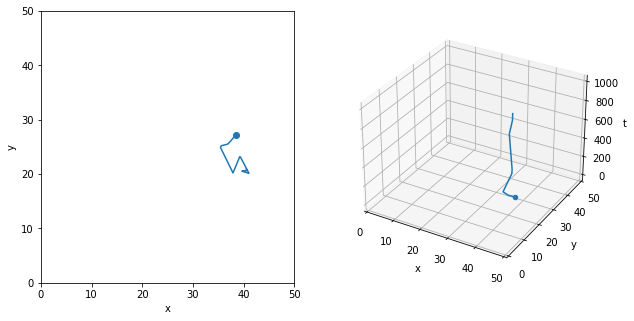

In [28]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

xs = anc_locs[0,:,0,0]
ys = anc_locs[0,:,0,1]
ts = times

ax1.scatter(xs[0], ys[0])
ax1.plot(xs, ys)
ax2.scatter(xs[0], ys[0], ts[0])
ax2.plot(xs, ys, ts)

ax1.set_xlim(0,50)
ax1.set_ylim(0,50)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('t')

plt.show()

And it might be fun to plot the lineages of multiple nodes at the same locus

In [29]:
loci = [0] #loci to locate ancestors at
times = range(0,1000,10) #times we want to locate ancestors
nodes = range(10) #sample nodes we want to locate ancestors of

anc_locs = sparg.locate(nodes=nodes, times=times, locations=locations, shared_times=np.array(shared_times)[loci], samples=np.array(samples)[loci], important=False)

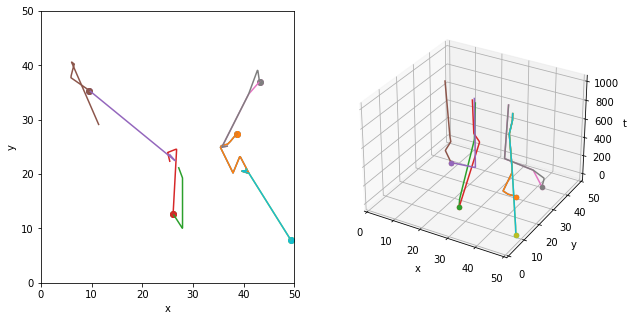

In [30]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

for i in range(len(nodes)):

    xs = anc_locs[0,:,i,0]
    ys = anc_locs[0,:,i,1]
    ts = times

    ax1.scatter(xs[0], ys[0])
    ax1.plot(xs, ys)
    ax2.scatter(xs[0], ys[0], ts[0])
    ax2.plot(xs, ys, ts)

ax1.set_xlim(0,50)
ax1.set_ylim(0,50)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('t')

plt.show()

If we go back far enough these should form a spatial representation of the tree

In [31]:
loci = [0] #loci to locate ancestors at

tmrca = np.array(shared_times)[loci[0],0,0,0,0] #tmrca at first locus
times = [i for i in range(0,int(tmrca),100)] #times we want to locate ancestors

nodes = range(10) #sample nodes we want to locate ancestors of

anc_locs = sparg.locate(nodes=nodes, times=times, locations=locations, shared_times=np.array(shared_times)[loci], samples=np.array(samples)[loci], important=False)

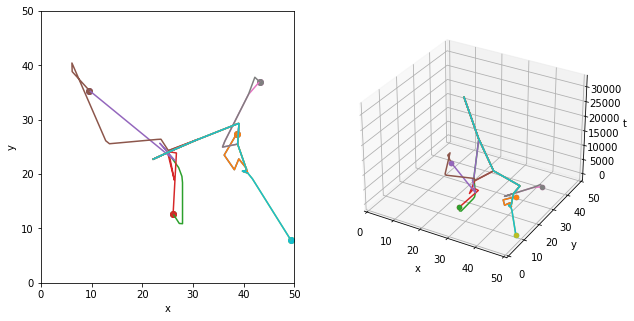

In [32]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

for i in range(len(nodes)):

    xs = anc_locs[0,:,i,0]
    ys = anc_locs[0,:,i,1]
    ts = times

    ax1.scatter(xs[0], ys[0])
    ax1.plot(xs, ys)
    ax2.scatter(xs[0], ys[0], ts[0])
    ax2.plot(xs, ys, ts)

ax1.set_xlim(0,50)
ax1.set_ylim(0,50)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('t')

plt.show()

Or we can plot the lineages for just one sample at multiple loci, showing how the ancestors of a sample spread out back in time

In [33]:
loci = range(10) #loci to locate ancestors at
times = range(0,1000,10) #times we want to locate ancestors
nodes = [0] #sample nodes we want to locate ancestors of

anc_locs = sparg.locate(nodes=nodes, times=times, locations=locations, shared_times=np.array(shared_times)[loci], samples=np.array(samples)[loci], important=False)

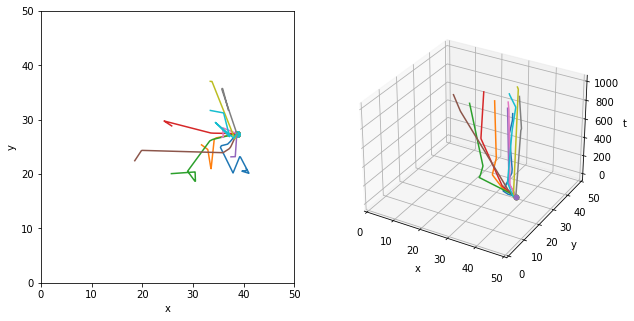

In [34]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

for i in range(len(loci)):

    xs = anc_locs[i,:,0,0]
    ys = anc_locs[i,:,0,1]
    ts = times

    ax1.scatter(xs[0], ys[0])
    ax1.plot(xs, ys)
    ax2.scatter(xs[0], ys[0], ts[0])
    ax2.plot(xs, ys, ts)

ax1.set_xlim(0,50)
ax1.set_ylim(0,50)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('t')

plt.show()

### Epochs

We can also locate ancestors in a model with multiple epochs

In [14]:
nodes = [0] #sample nodes we want to locate ancestors of
loci = [0] #loci to locate ancestors at
times = [100] #times we want to locate ancestors

tsplits = [100]
dispersal_rate = [mle_epochs.x for _ in loci] #now we need to give a dispersal rate because we find locations numerically when more than one epoch

sparg.locate(nodes=nodes, times=times, locations=locations, shared_times=np.array(shared_times)[loci], samples=np.array(samples)[loci], important=False, tsplits=tsplits, dispersal_rate=dispersal_rate)

array([[[[36.53260786, 23.00141242]]]])

### Time cutoffs

We can of course also locate ancestors in subtrees, if the trees have been chopped off at ```tCutoff```

In [16]:
tCutoff = [1000]

shared_times, samples = sparg.trees.process(trees=trees, important=False, tCutoff=tCutoff)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
nodes = [0] #sample nodes we want to locate ancestors of
loci = [0] #loci to locate ancestors at
times = [100] #times we want to locate ancestors

sparg.locate(nodes=nodes, times=times, locations=locations, shared_times=[shared_times[i] for i in loci], samples=[samples[i] for i in loci], important=False, tCutoff=tCutoff)

array([[[[36.15798139, 23.48258347]]]])

## Importance sampling over inferred trees

We can do the same thing with the inferred trees, again using importance sampling.

First load the processed trees again

In [61]:
processed_trees = np.load(inf_processed_trees, allow_pickle=True)
shared_times = processed_trees['shared_times']
samples = processed_trees['samples']
coal_times = processed_trees['coal_times']
logpcoals = processed_trees['logpcoals']

This time we need the dispersal rate because we have multiple trees sampled at a locus, meaning we need to average log likelihoods over these trees, and the log likelhoods depend on the dispersal rate

In [28]:
mle_inf = np.load(datadir + 'mle_inf.npy', allow_pickle=True).item()

Now locate one particular ancestor

In [29]:
nodes = [0] #sample nodes we want to locate ancestors of
loci = [0] #loci to locate ancestors at
times = [100] #times we want to locate ancestors

x0 = [25, 25]
bnds = ((0,50),(0,50))

sparg.locate(nodes=nodes, times=times, locations=reordered_locations, shared_times=shared_times[loci], samples=samples[loci], dispersal_rate=[mle_inf.x for _ in loci], coal_times=coal_times[loci], logpcoals=logpcoals[loci], x0=x0, bnds=bnds)

array([[[[37.65689633, 20.01612049]]]])

Or make a spatial tree

In [38]:
loci = [0] #loci to locate ancestors at

tmrca = shared_times[loci[0],0,0,0,0] #tmrca at first locus
times = [i for i in range(10, int(tmrca), int(tmrca/100))] #times we want to locate ancestors

nodes = range(10) #sample nodes we want to locate ancestors of

anc_locs = sparg.locate(nodes=nodes, times=times, locations=reordered_locations, shared_times=shared_times[loci], samples=samples[loci], dispersal_rate=[mle_inf.item().x for _ in loci], coal_times=coal_times[loci], logpcoals=logpcoals[loci], x0=x0, bnds=bnds)

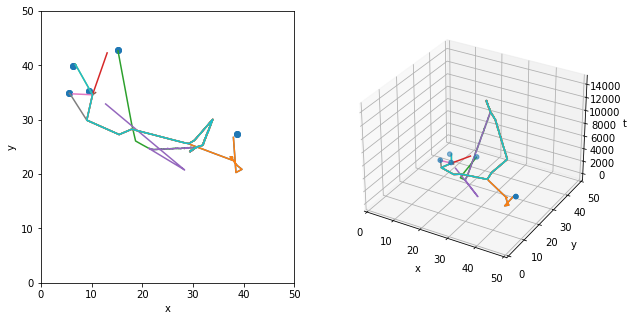

In [39]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(reordered_locations[nodes,0], reordered_locations[nodes,1])
ax2.scatter(reordered_locations[nodes,0], reordered_locations[nodes,1], 0)

for i in range(len(nodes)):

    xs = anc_locs[0,:,i,0]
    ys = anc_locs[0,:,i,1]
    ts = times

    ax1.plot(xs, ys)
    ax2.plot(xs, ys, ts)

ax1.set_xlim(0,50)
ax1.set_ylim(0,50)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('t')

plt.show()

Or plot the spread of ancestry from one sample

In [40]:
loci = range(10) #loci to locate ancestors at
times = range(10,1000,10) #times we want to locate ancestors
nodes = [0] #sample nodes we want to locate ancestors of

anc_locs = sparg.locate(nodes=nodes, times=times, locations=reordered_locations, shared_times=shared_times[loci], samples=samples[loci], dispersal_rate=[mle_inf.item().x for _ in loci], coal_times=coal_times[loci], logpcoals=logpcoals[loci], x0=x0, bnds=bnds)

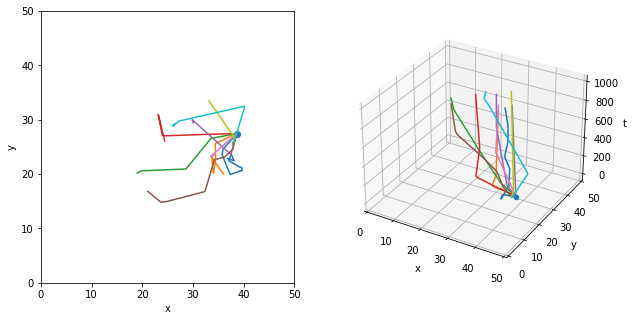

In [41]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(reordered_locations[nodes,0], reordered_locations[nodes,1])
ax2.scatter(reordered_locations[nodes,0], reordered_locations[nodes,1], 0)

for i in range(len(loci)):

    xs = anc_locs[i,:,0,0]
    ys = anc_locs[i,:,0,1]
    ts = times

    ax1.plot(xs, ys)
    ax2.plot(xs, ys, ts)

ax1.set_xlim(0,50)
ax1.set_ylim(0,50)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('t')

plt.show()

### Epochs

We can also do this with epochs

In [62]:
nodes = [0] #sample nodes we want to locate ancestors of
loci = [0] #loci to locate ancestors at
times = [100] #times we want to locate ancestors

x0 = [25, 25]
bnds = ((0,50),(0,50))

tsplits = [100]

mle_inf_epochs = np.load(datadir + 'mle_inf_epochs.npy', allow_pickle=True).item()
dispersal_rate = [mle_inf_epochs.x for _ in loci]

sparg.locate(nodes=nodes, times=times, locations=reordered_locations, shared_times=shared_times[loci], samples=samples[loci], dispersal_rate=dispersal_rate, coal_times=coal_times[loci], logpcoals=logpcoals[loci], x0=x0, bnds=bnds, tsplits=tsplits)

array([[[[38.11204142, 20.91176902]]]])

### Time cutoffs

Or with tCutoffs

In [59]:
nodes = [0] #sample nodes we want to locate ancestors of
loci = [0] #loci to locate ancestors at
times = [100] #times we want to locate ancestors

which_trees, intervals = sparg.trees.choose_loci(ts=inf_ts, which=loci, mode='site')

fname = datadir + 'slim_sim_simple'
infile = fname + '_popsize' #prefix of anc/mut files to sample from
coalfile = infile + '.coal' #file with epochs and population sizes
trees = sparg.relate.sample(which_trees=which_trees, intervals=intervals, PATH_TO_RELATE=PATH_TO_RELATE, infile=infile, coalfile=coalfile, U=U, M=10)

epochs, Nes = sparg.relate.get_epochs(coalfile) #to get the probability of the coalescence times under the coalescent we need the pop size through time
shared_times, samples, coal_times, logpcoals = sparg.trees.process(trees=trees, epochs=epochs, Nes=Nes, tCutoff=tCutoff)

mle_inf_cut = np.load(datadir + 'mle_inf_cut.npy', allow_pickle=True).item()
dispersal_rate = [mle_inf_cut.x for _ in which_trees]

x0 = [25, 25]
bnds = ((0,50),(0,50))

sparg.locate(nodes=nodes, times=times, locations=reordered_locations, shared_times=shared_times, samples=samples, dispersal_rate=dispersal_rate, coal_times=coal_times, logpcoals=logpcoals, x0=x0, bnds=bnds, tCutoff=tCutoff)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

array([[[[37.67537189, 20.00898929]]]])

### BLUPs

Above we've located ancestors at the location that maximizes the (weighted) average likelihood. Alternatively, we can locate ancestors at the (weighted) average of the locations that maximize the likehood of each sampled tree. The latter does not depend on the dispersal rate and is, in principle, faster to compute because we do not have to do a numerical search. We simply pass a ```BLUP=True``` option to ```locate```

In [27]:
processed_trees = np.load(inf_processed_trees, allow_pickle=True)
shared_times = processed_trees['shared_times']
samples = processed_trees['samples']
coal_times = processed_trees['coal_times']
logpcoals = processed_trees['logpcoals']

In [42]:
loci = range(10) #loci to locate ancestors at
times = range(10,1000,10) #times we want to locate ancestors
nodes = [0] #sample nodes we want to locate ancestors of

# note that we have to supply a branching rate (phi) for importance sampling
phi = mle_inf.item().x[-1]

anc_locs = sparg.locate(nodes=nodes, times=times, locations=reordered_locations, shared_times=shared_times[loci], samples=samples[loci], coal_times=coal_times[loci], logpcoals=logpcoals[loci], BLUP=True, phi=phi)

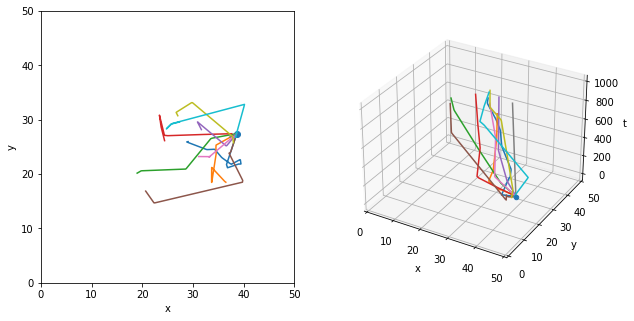

In [43]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(reordered_locations[nodes,0], reordered_locations[nodes,1])
ax2.scatter(reordered_locations[nodes,0], reordered_locations[nodes,1], 0)

for i in range(len(loci)):

    xs = anc_locs[i,:,0,0]
    ys = anc_locs[i,:,0,1]
    ts = times

    ax1.plot(xs, ys)
    ax2.plot(xs, ys, ts)

ax1.set_xlim(0,50)
ax1.set_ylim(0,50)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('t')

plt.show()

## Comparing true and inferred ancestral locations

Finally let's see how well our inferences do in predicting the true ancestral locations.

Let's pick some nodes, some locations in the genome, and some times to locate ancestors at

In [126]:
nodes = [0,10,20] #sample nodes we want to locate ancestors of
sites = [0] #sites to locate ancestors at
times = range(1,100) #times we want to locate ancestors

# get the order of individuals in the true tree sequence
node_list = []
for ind in rsts.individuals():
    if ind.id in range(k):
        node_list.append(ind.nodes)
node_list = np.array(node_list).flatten()

nodes_true = node_list[nodes] #to line up the nodes between the true and inferred trees
np.all(reordered_locations[nodes] == locations[nodes_true]) #check things are lined up

True

Now infer the locations using the tree trees

In [120]:
which_trees, intervals = sparg.trees.choose_loci(ts=rsts, which=sites, mode='site')
trees = sparg.trees.get_dendropy_trees(treefile=rsts, which_trees=which_trees, from_ts=True)
shared_times, samples = sparg.trees.process(trees=trees, important=False) #use sparg to process the trees

anc_locs_true_trees = sparg.locate(nodes=nodes_true, times=times, locations=locations, shared_times=shared_times, samples=samples, important=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

And infer the locations using the inferred trees

In [121]:
which_trees, intervals = sparg.trees.choose_loci(ts=inf_ts, which=sites, mode='site')

fname = datadir + 'slim_sim_simple'
infile = fname + '_popsize' #prefix of anc/mut files to sample from
coalfile = infile + '.coal' #file with epochs and population sizes
trees = sparg.relate.sample(which_trees=which_trees, intervals=intervals, PATH_TO_RELATE=PATH_TO_RELATE, infile=infile, coalfile=coalfile, U=U, M=10)

epochs, Nes = sparg.relate.get_epochs(coalfile) #to get the probability of the coalescence times under the coalescent we need the pop size through time
shared_times, samples, coal_times, logpcoals = sparg.trees.process(trees=trees, epochs=epochs, Nes=Nes)

mle_inf = np.load(datadir + 'mle_inf.npy', allow_pickle=True).item()

anc_locs_inf_trees = sparg.locate(nodes=nodes, times=times, locations=reordered_locations, shared_times=shared_times, samples=samples, dispersal_rate=[mle_inf.x for _ in which_trees], coal_times=coal_times, logpcoals=logpcoals, x0=x0, bnds=bnds)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Now to get the true locations, we first make a simplified tree sequence while keeping unary nodes (so that we can locate ancestors along branches)

In [127]:
fname = datadir + 'slim_sim.trees'
fname_simple = datadir + 'slim_sim_simple_unary.trees'

try:

    # load the simplified tree sequence
    usts = pyslim.load(fname_simple)

except:
    
    ts = pyslim.load(fname)

    # sample present-day individuals
    inds_alive = ts.individuals_alive_at(0) #individuals alive at sampling time
    inds_alive = [i for i in inds_alive if ts.individual(i).time == 0.0] #just the current gen (their parents are still alive at the time the sim ended)
    np.random.seed(1)
    inds_sampled = np.random.choice(inds_alive, k, replace=False) #select k individuals randomly from current generation

    # get nodes (haploid genomes) of present-day samples
    nodes_sampled = [] #empty vector for nodes
    for ind in inds_sampled: #for each individual
        nodes_sampled.append(ts.individual(ind).nodes[0]) #append first haploid genome
        nodes_sampled.append(ts.individual(ind).nodes[1]) #append second haploid genome

    usts = ts.simplify(nodes_sampled, keep_unary=True) #keeping the unary nodes to locate ancestors along branches
    usts.dump(fname_simple)

usts

We need to do some rearranging to find the same nodes as above

In [131]:
ixs = [usts.node(i).individual for i in range(2*k)] #individual associated with each sampled node
ulocations = np.array([usts.individual(i).location for i in ixs])[:,:2] #location associated with individual of each node

unode_list = []
for ind in usts.individuals_alive_at(0):
    if usts.individual(ind).id in range(k):
        unode_list.append(usts.individual(ind).nodes)
unode_list = np.array(unode_list).flatten()

nodes_truth = unode_list[nodes] #to line up the nodes between the true and unary trees
np.all(reordered_locations[nodes] == ulocations[nodes_truth]) #check things are lined up

True

Then we loop up the tree from the nodes of interest, getting the locations of the parents of the parents of the parents ...

In [132]:
treeseq = usts
maxtime = times[-1]

# loop over trees of interest
true_xs = []
true_ys = []
true_zs = []
for i in sites:
    
    tree = treeseq.at(i)

    # loop over samples of interest
    true_xs_i = []
    true_ys_i = []
    true_zs_i = []
    for node in nodes_truth:

        xs = []
        ys = []
        zs = []

        # get location of sample
        ind = treeseq.individual(treeseq.node(node).individual)
        x,y = ind.location[:2]
        z = ind.time
        xs.append(x)
        ys.append(y)
        zs.append(z)

        # now move up this lineage to maxtime, getting locations of ancestors
        # note this is redundant since lineages will coalesce
        while z < maxtime-1:
            node = tree.get_parent(node)

            ind = treeseq.individual(treeseq.node(node).individual)
            x,y = ind.location[:2]
            z = ind.time
            xs.append(x)
            ys.append(y)
            zs.append(z)
            
        true_xs_i.append(xs)
        true_ys_i.append(ys)
        true_zs_i.append(zs)
        
    true_xs.append(true_xs_i)
    true_ys.append(true_ys_i)
    true_zs.append(true_zs_i)

And plot all together

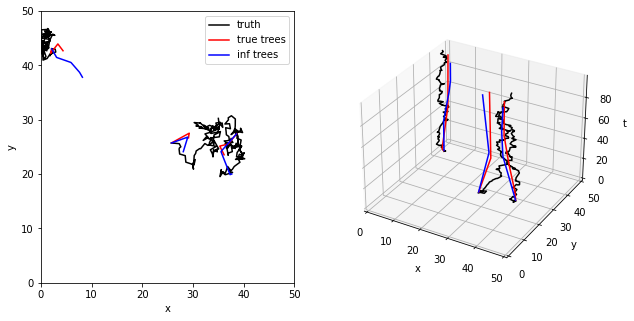

In [133]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

#truth
for i, (true_xs_i, true_ys_i, true_zs_i) in enumerate(zip(true_xs, true_ys, true_zs)):
    for j, (xs, ys, zs) in enumerate(zip(true_xs_i, true_ys_i, true_zs_i)):
        if i==0 and j==0:
            ax1.plot(xs, ys, color='k', label='truth')
        else:
            ax1.plot(xs, ys, color='k')        
        ax2.plot(xs, ys, zs, color='k')

# true tree inference
for i,_ in enumerate(sites):
    for j,_ in enumerate(nodes):
        if i == 0 and j == 0:
            ax1.plot(anc_locs_true_trees[i,:,j,0], anc_locs_true_trees[i,:,j,1], color='r', label='true trees')
        else:
            ax1.plot(anc_locs_true_trees[i,:,j,0], anc_locs_true_trees[i,:,j,1], color='r')
        ax2.plot(anc_locs_true_trees[i,:,j,0], anc_locs_true_trees[i,:,j,1], times, color='r')

# inferred tree inference
for i,_ in enumerate(sites):
    for j,_ in enumerate(nodes):
        if i == 0 and j == 0:
            ax1.plot(anc_locs_inf_trees[i,:,j,0], anc_locs_inf_trees[i,:,j,1], color='b', label='inf trees')
        else:
            ax1.plot(anc_locs_inf_trees[i,:,j,0], anc_locs_inf_trees[i,:,j,1], color='b')
        ax2.plot(anc_locs_inf_trees[i,:,j,0], anc_locs_inf_trees[i,:,j,1], times, color='b')

for ax in [ax1, ax2]: 
    ax.set_xlim(0,50)
    ax.set_ylim(0,50)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

ax1.legend()
ax2.set_zlabel('t')

plt.show()

The predictions at a particular locus are not always very accurate due to the increasing uncertainty back in time and the limited amount of information in one tree. For that reason we often will want to predict where many of an individuals ancestors were at some point in the past, which should better capture the truth.

So let's choose just one node at a few times and ask where the ancestors were at many loci

In [144]:
nodes = [0] #sample nodes we want to locate ancestors of
Linf = inf_ts.last().interval.right
sites = range(0, int(Linf), int(Linf/100)) #sites to locate ancestors at
times = [100, 200, 300, 400, 500] #times we want to locate ancestors

nodes_true = node_list[nodes] #to line up the nodes between the true and inferred trees
nodes_truth = unode_list[nodes] #to line up the nodes between the true and unary trees

Now infer the locations using the tree trees

In [135]:
which_trees, intervals = sparg.trees.choose_loci(ts=rsts, which=sites, mode='site')
trees = sparg.trees.get_dendropy_trees(treefile=rsts, which_trees=which_trees, from_ts=True)
shared_times, samples = sparg.trees.process(trees=trees, important=False) #use sparg to process the trees

anc_locs_true_trees = sparg.locate(nodes=nodes_true, times=times, locations=locations, shared_times=shared_times, samples=samples, important=False)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

And infer the locations using the inferred trees

In [138]:
which_trees, intervals = sparg.trees.choose_loci(ts=inf_ts, which=sites, mode='site')

fname = datadir + 'slim_sim_simple'
infile = fname + '_popsize' #prefix of anc/mut files to sample from
coalfile = infile + '.coal' #file with epochs and population sizes
trees = sparg.relate.sample(which_trees=which_trees, intervals=intervals, PATH_TO_RELATE=PATH_TO_RELATE, infile=infile, coalfile=coalfile, U=U, M=10)

epochs, Nes = sparg.relate.get_epochs(coalfile) #to get the probability of the coalescence times under the coalescent we need the pop size through time
shared_times, samples, coal_times, logpcoals = sparg.trees.process(trees=trees, epochs=epochs, Nes=Nes)

mle_inf = np.load(datadir + 'mle_inf.npy', allow_pickle=True).item()

anc_locs_inf_trees = sparg.locate(nodes=nodes, times=times, locations=reordered_locations, shared_times=shared_times, samples=samples, dispersal_rate=[mle_inf.x for _ in which_trees], coal_times=coal_times, logpcoals=logpcoals, x0=x0, bnds=bnds)

Now get the true locations

In [148]:
treeseq = usts
maxtime = times[-1]

# loop over trees of interest
true_xs = []
true_ys = []
true_zs = []
# for i in sites:    
#     tree = treeseq.at(i)
i = 0
for tree in treeseq.trees():
    if i < len(sites):
        if tree.interval[0] <= sites[i] and sites[i] < tree.interval[1]: 
            i += 1

            # loop over samples of interest
            true_xs_i = []
            true_ys_i = []
            true_zs_i = []
            for node in nodes_truth:

                xs = []
                ys = []
                zs = []

                # get location of sample
                ind = treeseq.individual(treeseq.node(node).individual)
                x,y = ind.location[:2]
                z = ind.time
                xs.append(x)
                ys.append(y)
                zs.append(z)

                # now move up this lineage to maxtime, getting locations of ancestors
                # note this is redundant since lineages will coalesce
                while z < maxtime-1:
                    node = tree.get_parent(node)

                    ind = treeseq.individual(treeseq.node(node).individual)
                    x,y = ind.location[:2]
                    z = ind.time
                    xs.append(x)
                    ys.append(y)
                    zs.append(z)

                true_xs_i.append(xs)
                true_ys_i.append(ys)
                true_zs_i.append(zs)

            true_xs.append(true_xs_i)
            true_ys.append(true_ys_i)
            true_zs.append(true_zs_i)

And plot

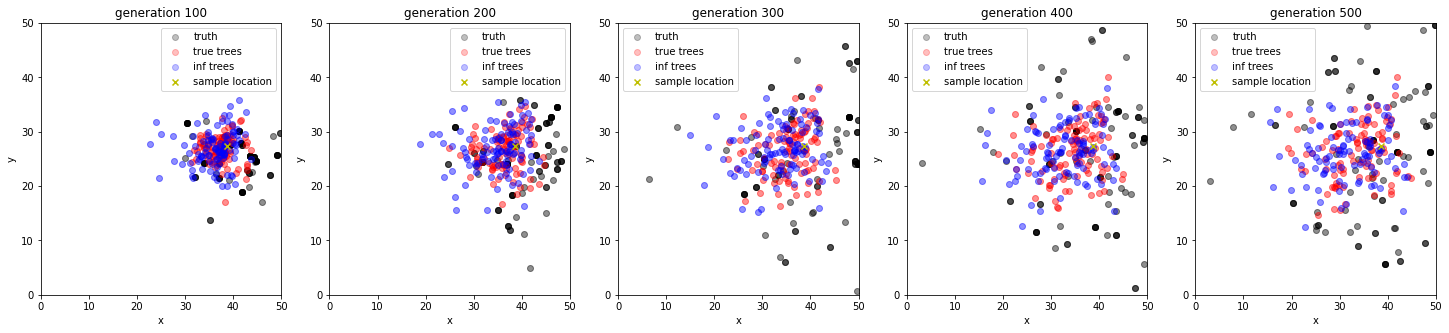

In [149]:
fig, axes = plt.subplots(1, len(times), figsize=(25,5))

for i,ax in enumerate(axes):
    
    for j in enumerate(nodes):
        
        ax.scatter(np.array(true_xs)[:,j,times[i]-1], np.array(true_ys)[:,j,times[i]-1], color='k', alpha=0.25, label='truth')
        ax.scatter(anc_locs_true_trees[:,i,j,0], anc_locs_true_trees[:,i,j,1], color='r', alpha=0.25, label='true trees')
        ax.scatter(anc_locs_inf_trees[:,i,j,0], anc_locs_inf_trees[:,i,j,1], color='b', alpha=0.25, label='inf trees')
        ax.scatter(locations[nodes_true,0], locations[nodes_true,1], marker='x', color='y', label='sample location')

    ax.set_xlim(0,50)
    ax.set_ylim(0,50)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.set_title('generation %d' %times[i])
    
plt.show()